In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [42]:
from google.colab import drive

In [43]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive.flush_and_unmount()

# Data analysis

In [44]:
#data loading
df_raw = pd.read_csv('/content/drive/MyDrive/Glen_Data/merged_top500_clean.csv', low_memory=False)
df = df_raw.dropna(subset=['RMax (Flop/s)', 'RPeak (Flop/s)', 'Processors']).copy()
df = df[(df['RMax (Flop/s)'] > 0) & (df['RPeak (Flop/s)'] > 0) & (df['Processors'] > 0)]

#performing feature egnineering. Efficency = rmax/rpeak, perf/core = rmax/processors (count), log_cores = logarithmic representation of processor count
df['efficiency']    = df['RMax (Flop/s)'] / df['RPeak (Flop/s)']
df['perf_per_core'] = df['RMax (Flop/s)'] / df['Processors']
df['log_cores']     = np.log(df['Processors'])

#one hot encoding of countries
df = pd.get_dummies(df, columns=['Country'], prefix='Country')
country_feats = [c for c in df.columns if c.startswith('Country_')]

#compiling features
numeric_feats = ['efficiency', 'perf_per_core', 'log_cores']
features = numeric_feats + country_feats
X = df[features].fillna(0)

#performing scaling, pca, and clustering
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
pca     = PCA(n_components=5, random_state=0).fit(X_scaled)
X_pca   = pca.transform(X_scaled)
clusters = KMeans(n_clusters=4, random_state=0).fit_predict(X_pca)
df['cluster'] = clusters

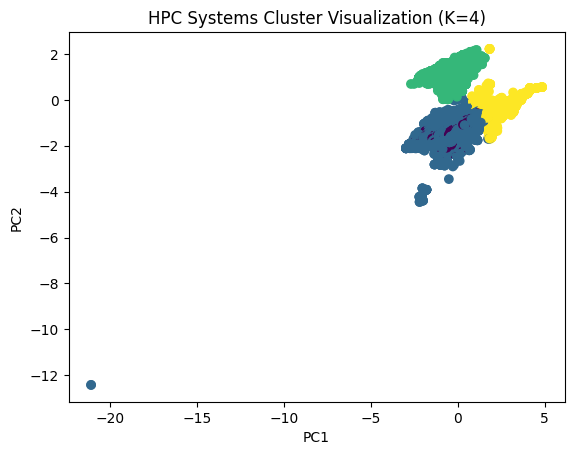

In [45]:
#Visualizing raw clusters
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('HPC Systems Cluster Visualization (K=4)')
plt.show()

In [46]:
#cluster breakdwon
cluster_profiles = df.groupby('cluster')[numeric_feats].agg(['mean','count'])
print("Cluster Profiles:\n", cluster_profiles)

#viewing winner allocation per cluster
df_raw_filtered = df_raw.loc[df.index].copy()
df_raw_filtered['cluster'] = clusters
winners = df_raw_filtered[df_raw_filtered['Rank'] == 1]
print("\nWinners per cluster:\n", winners['cluster'].value_counts().sort_index())

Cluster Profiles:
         efficiency        perf_per_core         log_cores       
              mean  count          mean  count       mean  count
cluster                                                         
0         0.707809   2295      4.050289   2295   6.702494   2295
1         0.726167  10831      5.108954  10831   7.302234  10831
2         0.671199  14492      4.172415  14492   7.358291  14492
3         0.509047   4382      3.335302   4382  10.419426   4382

Winners per cluster:
 cluster
1    17
2    36
3    11
Name: count, dtype: int64


In [47]:
#winner breakdown per country & year to see if a geographical trend is strongly present
by_year_country = winners.groupby(['Year','Country']).size().unstack(fill_value=0)
print("\nWinners by Year & Country:\n\n", by_year_country)



Winners by Year & Country:

 Country  China  Japan  United States
Year                                
1993         0      4              2
1996         0      2              0
1997         0      0              4
1999         0      0              3
2000         0      0              3
2002         0      5              0
2004         0      0              1
2005         0      0              5
2007         0      0              1
2008         0      0              3
2009         0      0              2
2010         1      0              0
2011         0      2              1
2012         0      0              1
2013         6      0              0
2016         4      0              0
2018         0      0              4
2020         0      4              0
2021         0      0              5
2024         0      0              1


In [35]:
#using randomforest to perform classification report to predict winners & non-winners
y = (df_raw_filtered['Rank'] == 1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=0
)
clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6387
           1       0.67      0.46      0.55        13

    accuracy                           1.00      6400
   macro avg       0.83      0.73      0.77      6400
weighted avg       1.00      1.00      1.00      6400



In [36]:
importances = pd.Series(clf.feature_importances_, index=features)
print("\nFeature Importances:\n", importances.sort_values(ascending=False))


Feature Importances:
 log_cores                  0.386729
perf_per_core              0.312253
efficiency                 0.274632
Country_United States      0.009544
Country_China              0.006932
                             ...   
Country_Peru               0.000000
Country_Nigeria            0.000000
Country_Philippines        0.000000
Country_Slovak Republic    0.000000
Country_Turkey             0.000000
Length: 68, dtype: float64


# Visualizations

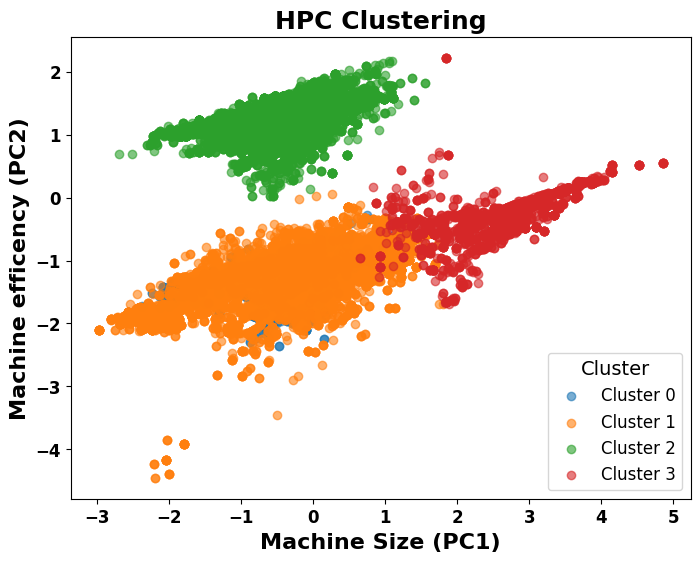

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for cluster_id in sorted(set(clusters)):
    mask = (clusters == cluster_id) & (X_pca[:,0] >= -10) #outlier points on raw data set with a PC1 value of ~-21, better visualization focuses on most of the centralized data
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )

plt.xlabel('Machine Size (PC1)', fontsize=16, fontweight='bold')
plt.ylabel('Machine efficency (PC2)', fontsize=16, fontweight='bold')
plt.title('HPC Clustering',
          fontsize=18, fontweight='bold')
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

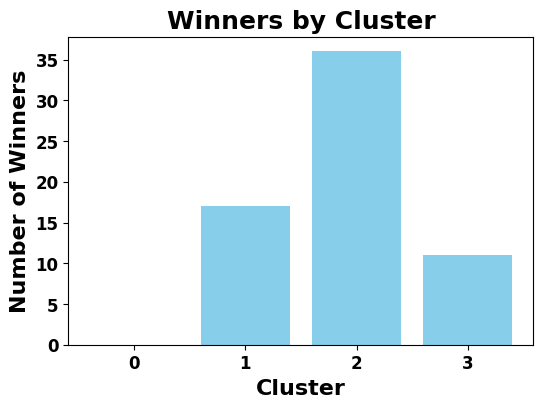

In [38]:
winners = df[df['Rank'] == 1]

#count winners for all clusters
winner_counts = winners['cluster'].value_counts().sort_index()
winner_counts = winner_counts.reindex(range(4), fill_value=0) #ensure all clusters are visualized (including cluster 0)

plt.figure(figsize=(6,4))
plt.bar(winner_counts.index.astype(str), winner_counts.values, color='skyblue')
plt.xlabel('Cluster', fontsize=16, fontweight='bold')
plt.ylabel('Number of Winners', fontsize=16, fontweight='bold')
plt.title('Winners by Cluster', fontsize=18, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

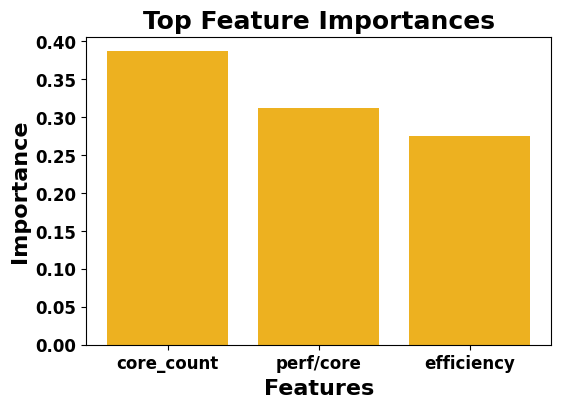

In [49]:
features = ['core_count', 'perf/core', 'efficiency']
importances = [0.386729, 0.312253, 0.274632] #values from data analysis above
matlab_yellow = (0.9290, 0.6940, 0.1250) #color selection of visualization

plt.figure(figsize=(6,4))
plt.bar(features, importances, color=matlab_yellow)
plt.xlabel('Features', fontsize=16, fontweight='bold')
plt.ylabel('Importance', fontsize=16, fontweight='bold')
plt.title('Top Feature Importances', fontsize=18, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()